# Data Analysis Interview Challenge
## Part 1 - Exploratory Data Analysis

The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15 minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the  underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.


In [11]:
#import packages for EDA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib_inline      
sns.set_theme()

In [12]:
# import in logings.json file
df = pd.read_json(r"..\ultimate_challenge\logins.json")


In [13]:
#check out the size and dtypes of the data columns
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB
None


,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [14]:
#review the last 5 rows of the data
df.tail()

,login_time
93137,1970-04-13 18:50:19
93138,1970-04-13 18:43:56
93139,1970-04-13 18:54:02
93140,1970-04-13 18:57:38
93141,1970-04-13 18:54:23


In [15]:
#identify if there are any duplicate logins in the dataset
dupes = df.duplicated()
df['is_dupe'] = dupes

duplicated_rows = df[df['is_dupe'] == True]
#count the number of duplicate rows
print(duplicated_rows.count())
#print the duplicated rows
print(duplicated_rows)

login_time    877
is_dupe       877
dtype: int64
               login_time  is_dupe
354   1970-01-02 10:59:52     True
434   1970-01-02 12:27:48     True
506   1970-01-02 15:08:27     True
524   1970-01-02 16:14:36     True
675   1970-01-02 22:03:36     True
...                   ...      ...
92051 1970-04-12 05:24:21     True
92367 1970-04-12 15:46:43     True
92439 1970-04-12 17:12:21     True
92986 1970-04-13 12:23:46     True
93022 1970-04-13 13:44:18     True

[877 rows x 2 columns]


In [16]:
#there appear to be 877 duplicate rows in the dataset
#we will drop these rows from the dataset where is_dupe == True
df = df[df['is_dupe'] == False] #filter out dupes       
df.info()   #check to see if the duplicates were removed

<class 'pandas.core.frame.DataFrame'>
Index: 92265 entries, 0 to 93141
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  92265 non-null  datetime64[ns]
 1   is_dupe     92265 non-null  bool          
dtypes: bool(1), datetime64[ns](1)
memory usage: 1.5 MB


In [17]:
#although the dtype is already established as dateime64[ns], I will validate that all the datetime entries are truly date time objects
df['login_time'] = pd.to_datetime(df['login_time'], errors='coerce')
#check for any invalid dates
invalid_dates = df['login_time'].isna().sum()
invalid_dates

0

In [18]:
#create bins for the day of the week
df['day_of_week'] = df['login_time'].dt.day_name()

#specify the order of the days of the week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

#convert the day_of_week column to a categorical column with the specific days of the week in order
df['day_of_week'] = pd.Categorical(df['day_of_week'], categories=day_order, ordered=True)

#create 96 bins for each 15 minute interval within a day
time_bins = pd.date_range("00:00", "23:59", freq="15min").time
bin_labels = list(range(95))  # 96 bins based on 4 pins per 24 hours
df['time_15min_bin'] = pd.cut(df['login_time'].dt.time, bins=time_bins, labels=bin_labels)
df 


,login_time,is_dupe,day_of_week,time_15min_bin
0,1970-01-01 20:13:18,False,Thursday,80
1,1970-01-01 20:16:10,False,Thursday,81
2,1970-01-01 20:16:37,False,Thursday,81
3,1970-01-01 20:16:36,False,Thursday,81
4,1970-01-01 20:26:21,False,Thursday,81
...,...,...,...,...
93137,1970-04-13 18:50:19,False,Monday,75
93138,1970-04-13 18:43:56,False,Monday,74
93139,1970-04-13 18:54:02,False,Monday,75
93140,1970-04-13 18:57:38,False,Monday,75


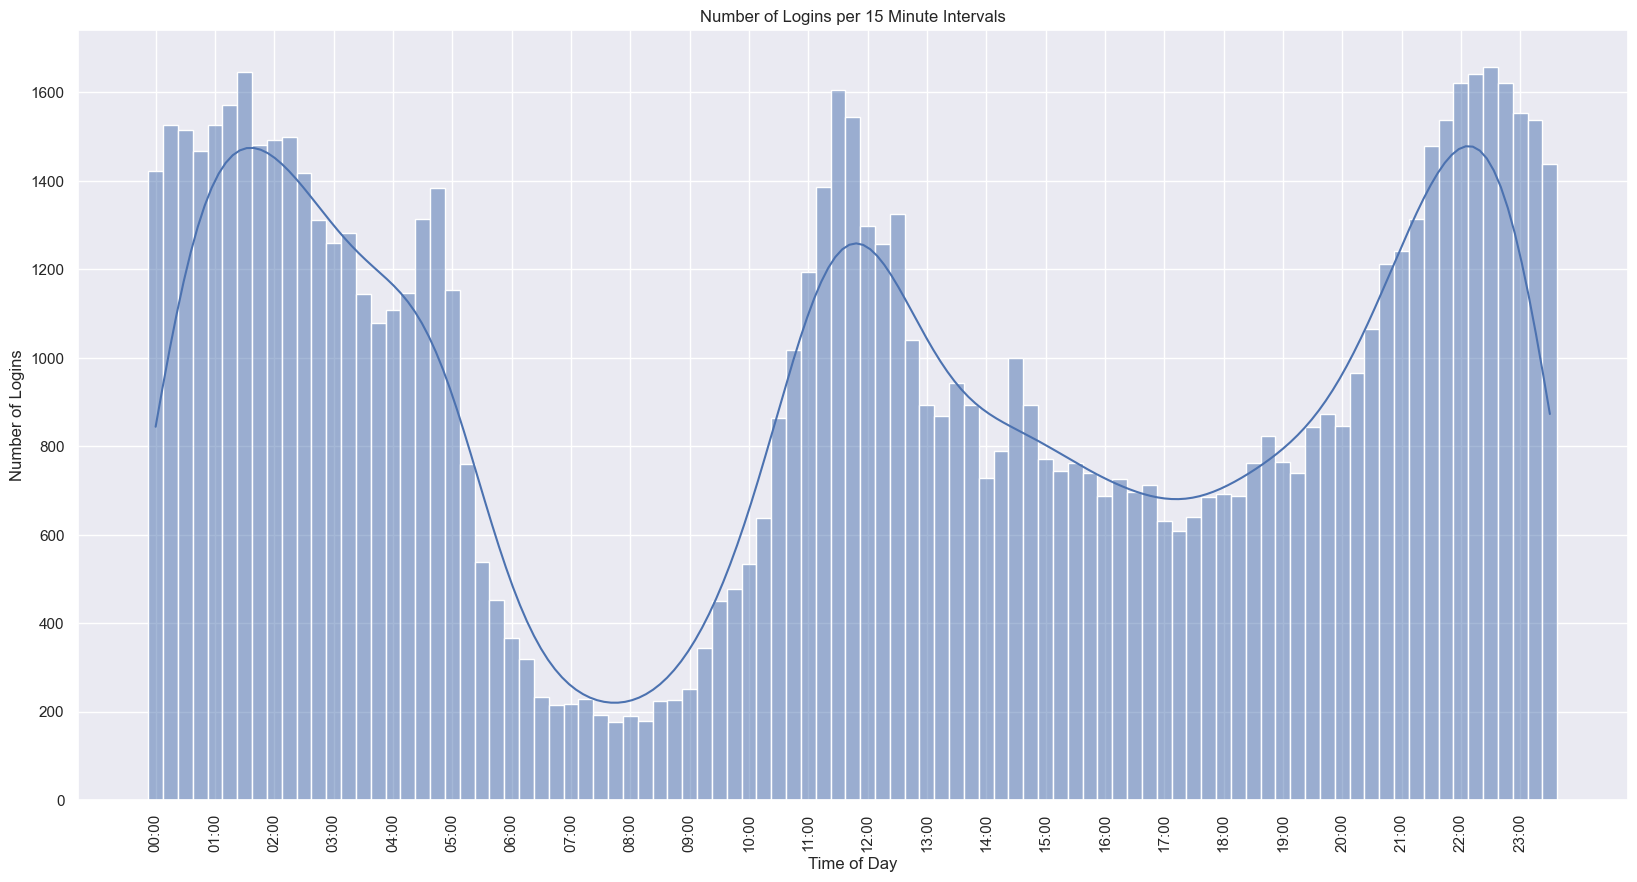

In [19]:
#plot a histogram with kde plot of the number of logins per 15 minute interval bins
plt.figure(figsize=(20,10))
sns.histplot(data=df, x='time_15min_bin', kde=True)

#customize my x-ticks to also display the time of day for every 4th tick (or hour)
ticks = list(range(0, time_bins.size, 4))
labels = [time_bins[i].strftime('%H:%M') for i in ticks]

plt.xticks(ticks=ticks, labels=labels, rotation=90)
plt.xlabel('Time of Day')
plt.ylabel('Number of Logins')
plt.title('Number of Logins per 15 Minute Intervals')

plt.show()


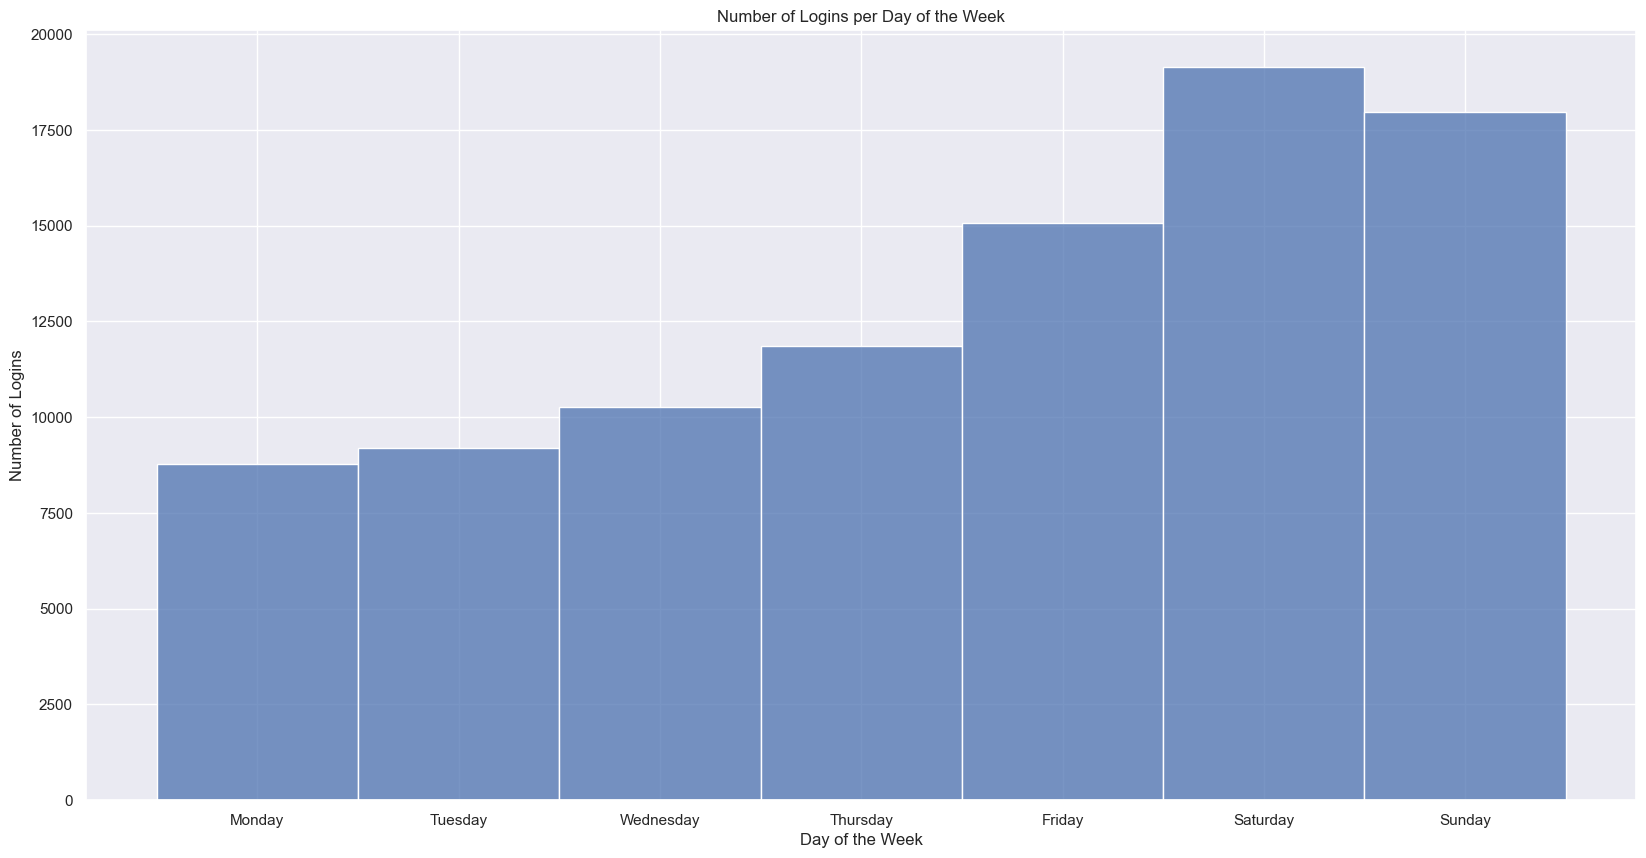

In [21]:
#plot a histogram plot of the number of logins per day of the week 
plt.figure(figsize=(20,10))
sns.histplot(data=df, x='day_of_week')    
plt.xlabel('Day of the Week')
plt.ylabel('Number of Logins')
plt.title('Number of Logins per Day of the Week')
plt.show()


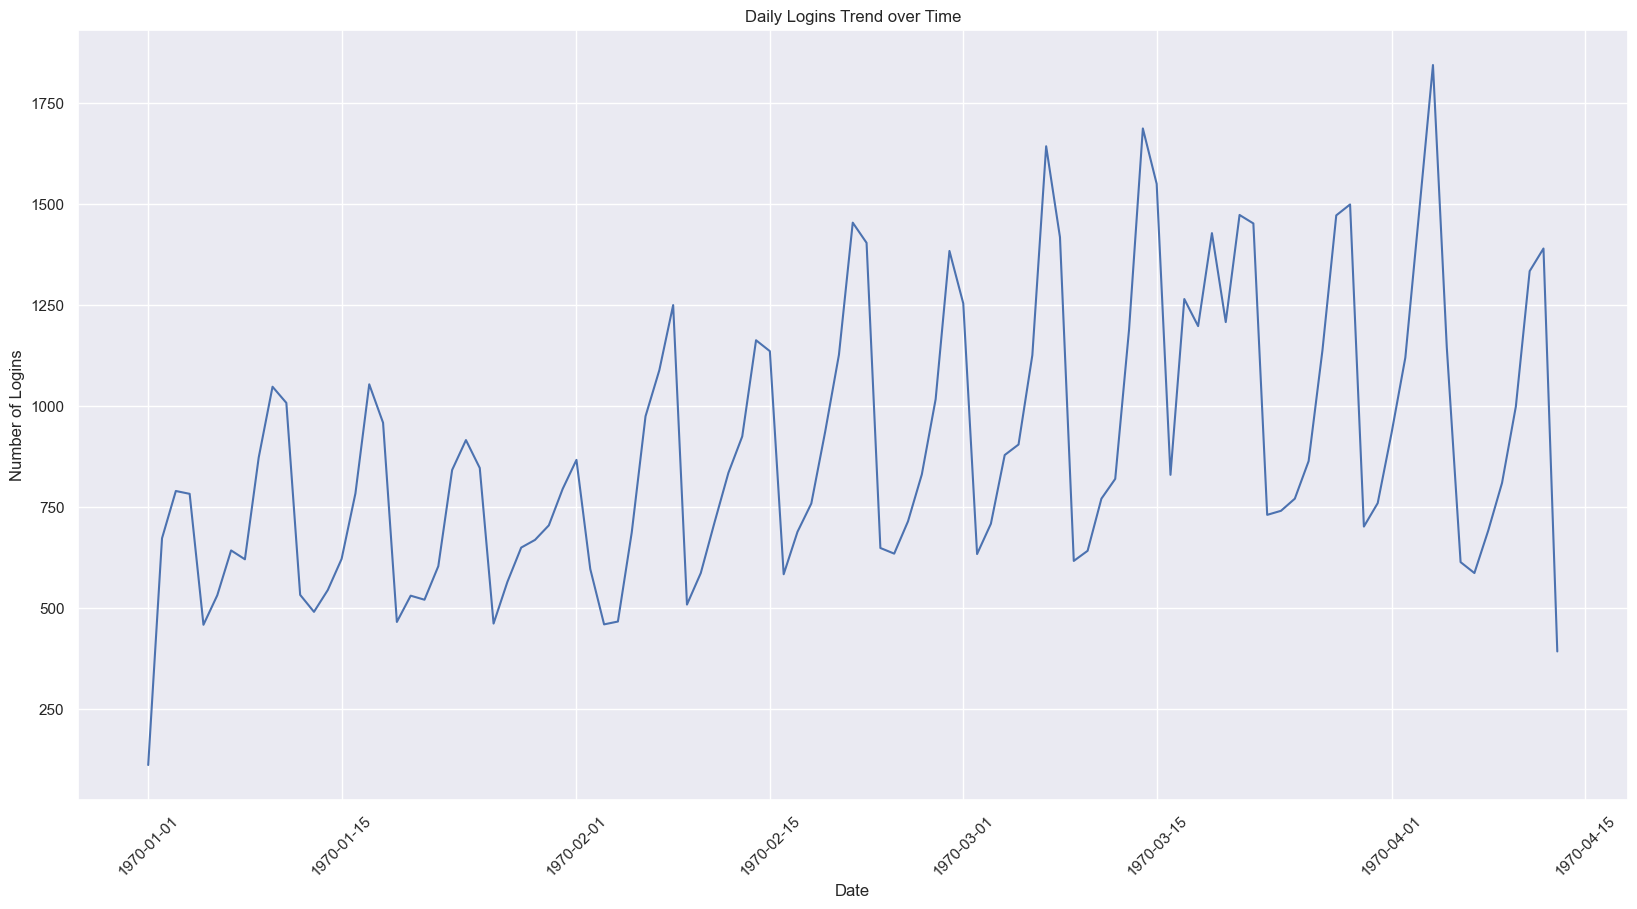

In [26]:
#group the data by the calendar date and count the number of logins per date
df['calendar_date'] = df['login_time'].dt.date  #extract the calendar date from the login_time
date_counts = df.groupby('calendar_date').size().reset_index(name='login_count')
#plot a line plot of the number of logins per caledar date  
plt.figure(figsize=(20,10))
sns.lineplot(data=date_counts, x='calendar_date', y='login_count')
plt.xticks(rotation=45)
# add title and labels to the plot
plt.xlabel('Date')
plt.ylabel('Number of Logins')
plt.title('Daily Logins Trend over Time')    
plt.show()



### EDA Findings

There were a total of 93,142 logins.  Of that total, we noted that there were potentially 877 duplicate records.  We assumed those were dupes and dropped them from the data. However, without a user id in the dataset, we could also have assumed that those specific times, 2 different users accessed the application at the same time 877 times within the dataset.  We also validated that all of the datetime values, were indeed valid datetimes.  No issues were noted here.

In order to complete the assignment, we created bins for every 15 minute interval throughout the day, and added a column for the day of the week.  These features were useful to note specific usage patterns for the users.  For example we noted that, there are more logins around 12:00 each day, perhaps during lunch breaks.  There is a slight lull in logins over the end of the work day / rush hour / dinner time.  However, logins pick-up again late into the evening around 10PM and 1:30AM.  

Looking at the logins by day of the week, we can also see that users are least active on Mondays and the most active on Saturdays.  This is where business knowledge would come into play.  How does this company report their login metrics?  If by week, do they start their week on Mondays or Sundays.  I have assumed Mondays are the start of their reporting week.  But this would obviously be better to adapt it to management's business reporting cycle.  

Lastly, by plotting this information by date, we can still clearly see that the day to day upward trend Mondays - Saturday/Sunday is very pronounced and is a pattern from week to week.  However, we can also see that there appears to be some kind of seasonality within this data as well.  There is a steadily increasing trend from January through the first week of April, and then a slight decline into the second week of April.  

## Part 2 ‐ Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.

 However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

1) What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

2) Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

    a) how you will implement the experiment

    b) what statistical test(s) you will conduct to verify the significance of the observation
 
    c) how you would interpret the results and provide recommendations to the city operations team along with any caveats.


*Note: The two cities of Gotham and Metropolis are not in the provided dataset; however, you do not need this information to answer Part 2.*




### Part 2 - Response

For this experiment, I would suggest utilizing A/B testing to determine if reimbursing all tolls will drive the desired driver partner behavior, which is to have them service trips in both cities.  The key measure of success for this experiment will be a measurable increase in the number of bookings the driver partners have servicing both cities, vs only serving their usual exclusive city.

The key metric I would use for this experiment is the total number of trips made in the target city as a proportion of total trips made for each driver partner.  This information should be relatively easy to capture, as starting and end points of trips and tolls paid, are likely available within the app. Either from driver partner profile information or historical data, we could also easily establish the “base” city for each driver partner.  This “target city trips” percentage metric can also be measured within a relatively short time-frame to determine the results.  

In order to implement A/B testing for this experiment, we need to gather some prerequisite information:
* determine our key metric, in this case we can define our conversion rate as the number of “target city trips” as percent of total trips per driver partner
* calculate our baseline, or current conversion rate for “target city trips”
* determine a success criteria, for example “we want to increase target city trips by 10%” (we would expect this to be defined by the Ultimate managers of the Metropolis and Gotham)
* verify that our data is available or easily obtainable

After the initial information gathering, we can start designing the experiment.  The first thing we should ascertain is the practical significance boundary.  In a real world scenario, we would be able to ask this of the stakeholders.  Here I would assume that this initiative is based on increasing our user engagement by having a higher availability level of driver partners and thus an increase in revenues.  We could then establish a revenue boundary that makes this experiment a success or not.  For example, stakeholders might establish that we need to increase revenues by $100 / driver partner each day.  Anything less than that, may make the costs associated with reimbursing tolls outweigh the potential revenue gains stakeholders are expecting.

Next, we need to determine a sufficient sample size for # of trips in our test to ensure we can meet the confidence level required by our stakeholders to detect our change.  We will assume a confidence level of 0.95, which will require a larger sample size.  Once we have the sample size for # of driver partners to include in our experiment, we will need to randomly assign our driver partners to the control group and the test group receiving the reimbursements of tolls.

I would suggest a 14 day timeline for this experiment.  It is still relatively short-term, but allows us to see two complete cycles for each day of the week for analyzing the results.

I would leverage hypothesis testing to verify the significance of the change.  Our null hypothesis would be that #of target city trips for the control group and #of target city trips for the treatment group will be the same.  At the conclusion of the experiment time frame, we should verify that we reached the sufficient sample size for the # of trips made.  We should also verify that we don’t have any biases in the data, for example all of the driver partners were from Gotham vs Metropolis as that could skew the results.  We would want them to be relatively equal.  We then determine our p-value (using the conversion rates of the control group and that of our treatment group); if it is low, we can reject the null hypothesis and assert that there is a statistical difference between our control and our treatment groups’ conversion rates of target city trips.

If our test has met our goals of increasing the # of targeted city trips and our success criteria, we would then present this information to our stakeholders.  We could show it in table form comparing our target city trip conversion rate of the control group vs the treatment group and provide the statistical significance and confidence interval.  We could also provide a visualization showing the distributions of the baseline conversion rates vs the treatment conversion rates.  Potential caveats that we may have to discuss with the stakeholder could involve external factors, such as a competitor’s campaigns or weather conditions that may impact our riders behavior.

## Part 3 - Predictive Modelling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.


We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.
 
The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
1. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have.  How valid is your model? Include any key indicators of model performance.
1. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider retention (again, a few sentences will suffice).

### Data description
* city: city this user signed up in
* phone: primary device for this user
* signup_date: date of account registration; in the form ‘YYYYMMDD’
* last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’
* avg_dist: the average distance in miles per trip taken in the first 30 days after signup
* avg_rating_by_driver: the rider’s average rating over all of their trips
* avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
* surge_pct: the percent of trips taken with surge multiplier > 1
* avg_surge: The average surge multiplier over all of this user’s trips
* trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up
* ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise
* weekday_pct: the percent of the user’s trips occurring during a weekday
